# Post Calibration Verification

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

#save inline outputs in jpeg to minimize ipynb size (10x reduction from default pngs)
%matplotlib inline
%config InlineBackend.figure_format = 'jpeg'


#interactive (requires restart jupyter)
# %matplotlib widget 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

import torch
import numpy as np
import pickle
import cv2
from IPython.display import Image, display
torch.set_printoptions(linewidth=120)
from eyehandcal.utils import detect_corners, rotmat,  find_parameter, mean_loss, quat2rotvec, build_proj_matrix, sim_data
from eyehandcal.utils import hand_marker_proj_world_camera, world_marker_proj_hand_camera


## Data Inspection

pos_ee_base tensor([0.3242, 0.2978, 0.2790])
ori_ee_base tensor([ 0.9514,  0.0493,  0.2558, -0.1640])
intrinsics[0] {'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0], 'fx': 608.8338623046875, 'fy': 607.3656005859375, 'height': 480, 'model': 'inverse_brown_conrady', 'ppx': 324.5666809082031, 'ppy': 239.71124267578125, 'width': 640}


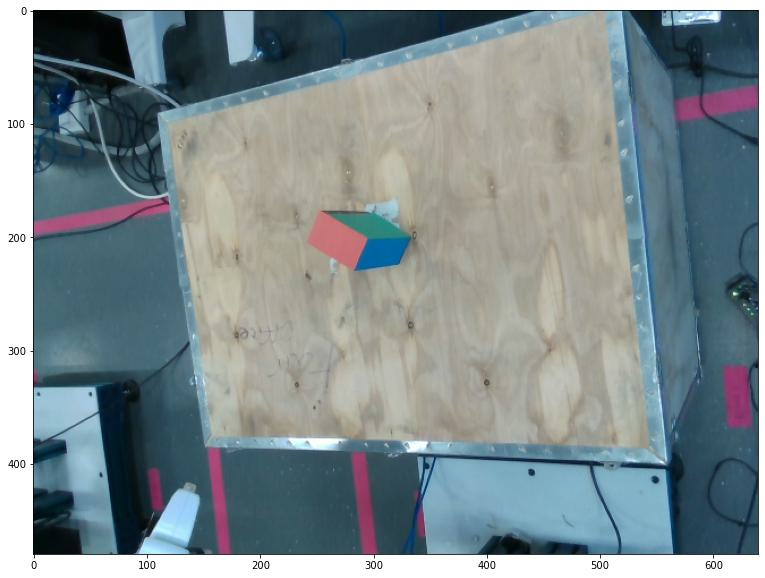

In [2]:
with open('caldata.pkl', 'rb') as f:
    data=pickle.load(f)
print('pos_ee_base', data[0]['pos'])
print('ori_ee_base', data[0]['ori'])
print('intrinsics[0]', list(data[0]['intrinsics'].values())[0])
plt.figure()
plt.imshow(data[0]['imgs'][0])

## Corner Detection

In [3]:
data=detect_corners(data, target_idx=1)

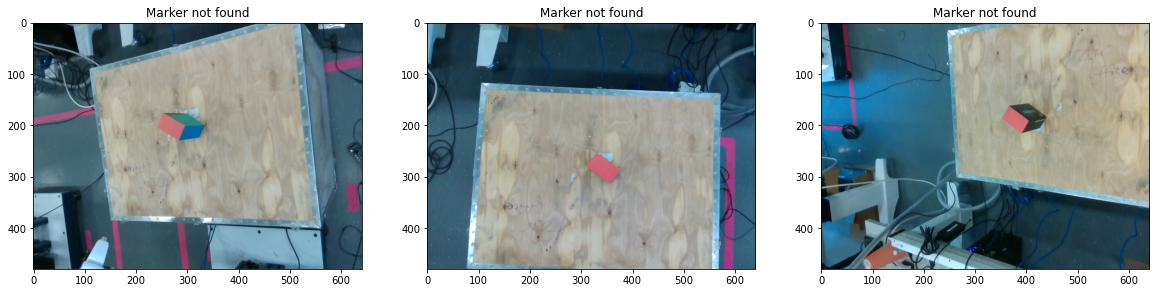

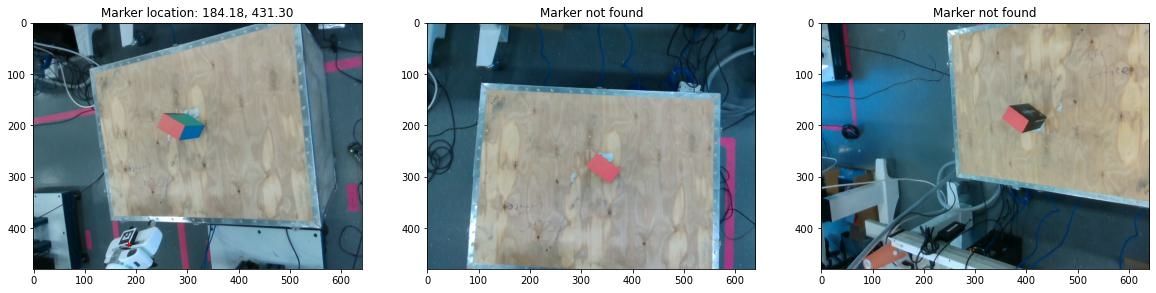

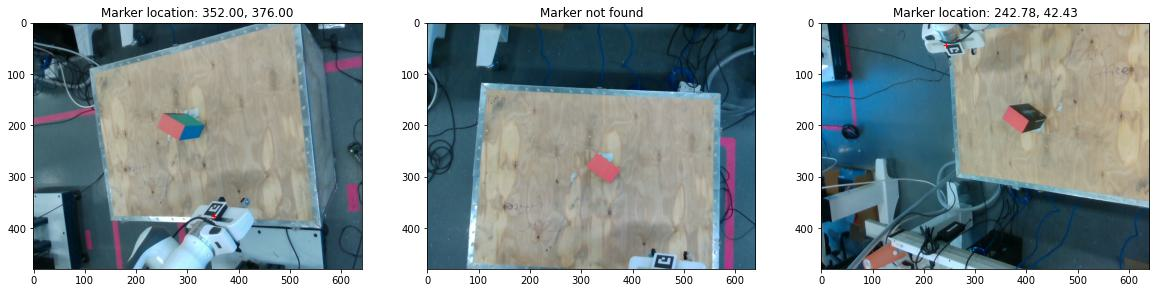

In [4]:
for i,d in enumerate(data[::20]):
    plt.figure()
    for j, img in enumerate(d['imgs']):
        plt.subplot(1,3,j+1)
        plt.imshow(img)
        if d['corners'][j] is not None:
            x,y = d['corners'][j]
            plt.plot(x,y, 'r+')
            plt.title(f'Marker location: {x:.2f}, {y:.2f}')
        else:
            plt.title('Marker not found')

In [5]:
# helper function
def extract_obs_data_std(data, camera_index):
    obs_data_std = []
    for d in data:
        if d['corners'][camera_index] is not None:
            obs_data_std.append((
                torch.tensor(d['corners'][camera_index], dtype=torch.float64),
                d['pos'].double(),
                quat2rotvec(d['ori'].double())
            ))

    ic = list(data[0]['intrinsics'].values())[camera_index]
    K=build_proj_matrix(
        fx=ic['fx'],
        fy=ic['fy'],
        ppx=ic['ppx'],
        ppy=ic['ppy'])
    return obs_data_std, K
    

## Visualize Re-projection Error

In [6]:
import json
with open('calibration.json') as f:
    calibrations=json.load(f)
params=[]
for c in calibrations:
    param=torch.tensor(np.hstack([c['camera_base_ori_rotvec'], c['camera_base_pos'],c['p_marker_ee']]))
    params.append(param)


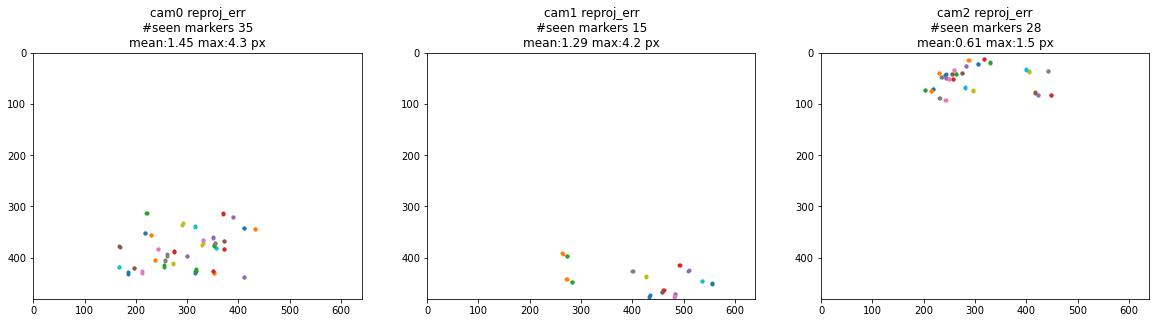

In [13]:
num_of_camera = len(data[0]['imgs'])
plt.figure()
for camera_index in range(num_of_camera):
    ax=plt.subplot(1,3, camera_index+1)
    obs_data_std, K = extract_obs_data_std(data, camera_index)
    err=[]
    for obs_marker, pos_ee_base, ori_ee_base in obs_data_std:
        with torch.no_grad():
            proj_marker = hand_marker_proj_world_camera(params[camera_index], pos_ee_base, ori_ee_base, K)
        
        err.append((proj_marker-obs_marker).norm())
        plt.plot((obs_marker[0], proj_marker[0]),
                 (obs_marker[1], proj_marker[1]),
                 '.-'
                )
    ax.set(xlim=(0, 640), ylim=(480, 0))
    ax.set_aspect('equal','box')
    errs = torch.stack(err)
    ax.set_title(f'cam{camera_index} reproj_err\n#seen markers {len(obs_data_std)}\nmean:{errs.mean():.2f} max:{errs.max():.2} px')        

## Visualize identified camera pose and marker in robot_base frame

In [14]:
import sophus as sp
from fairotag.scene import SceneViz

In [15]:
def makepose(rotvec, trans):
    return sp.SE3(rotmat(rotvec).detach().numpy(), trans.detach().numpy())

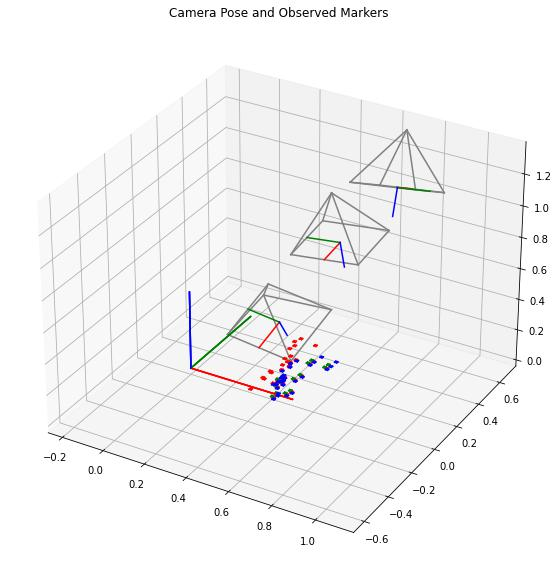

In [16]:
sv = SceneViz()
for i, param in enumerate(params):
    camera_base_ori = param[:3]
    camera_base_pos = param[3:6]
    
    sv.draw_camera(makepose(camera_base_ori, camera_base_pos), .3)
    sv.draw_axes(sp.SE3(), .5)
    
    #plot markers 
    obs_data_std, K = extract_obs_data_std(data, i)
    p_marker_ee = params[i][6:9]
    for d in obs_data_std:        
        p_marker_base = rotmat(d[2]).matmul(p_marker_ee) + d[1]
        pose_marker_base = makepose(torch.zeros(3), p_marker_base)
        sv.draw_marker(pose_marker_base, 0, 0.01, color=['r','g','b'][i])


plt.title('Camera Pose and Observed Markers')
sv.show()